In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KernelDensity
from statsmodels.nonparametric.kernel_regression import KernelReg
from matplotlib.backends.backend_pdf import PdfPages
from joblib import Parallel, delayed

In [2]:
def generate_data(num):
    samples = np.empty(shape=(0, 2))
    k = 2
    while samples.shape[0]<num:
        x_1 = np.random.uniform(0, 1, num)
        x_2 = np.random.uniform(0, 1, num)
        z = np.array([x_1, x_2]).T
        u = np.random.uniform(0, k, num)
        index = np.where(u <= np.power(x_1,x_2))[0]
        samples = np.append(samples, z[index,:], axis=0)
    # samples_num = samples[:num, :]
    return samples[:num, 0], samples[:num, 1]

In [3]:
def plot_err(xaxis, results, labels, xylabels, title=None, path=None, plottype=None):
    with PdfPages(f'{path}/{title.replace(" ", "_")}.pdf') as pdf:
        for i, (result, label) in enumerate(zip(results, labels)):
            if plottype=='semilogx':
                plt.semilogx(xaxis, result, label=label, color=f'C{i}')
            elif plottype=='semilogy': 
                plt.semilogy(xaxis, result, label=label, color=f'C{i}')
            elif plottype=='loglog': 
                plt.loglog(xaxis, result, label=label, color=f'C{i}')
            else: 
                plt.plot(xaxis, result, label=label, color=f'C{i}')
        if title:
            plt.title(title)
        plt.xlabel(xylabels[0])
        plt.ylabel(xylabels[1])
        plt.legend()
        plt.grid()
        if path:
            pdf.savefig()
        plt.show()
        # plt.cla()

In [4]:
num = int(1e3)
x_train, y_train = generate_data(num)
x_train

array([0.8478016 , 0.71428506, 0.79647049, 0.88416993, 0.9598347 ,
       0.51556786, 0.73271592, 0.15966912, 0.65929344, 0.73206966,
       0.87891057, 0.62193912, 0.18704527, 0.55242899, 0.98398599,
       0.31475614, 0.68094964, 0.17522908, 0.29720548, 0.21365086,
       0.52415146, 0.66826239, 0.25217393, 0.82737071, 0.70988185,
       0.63106275, 0.50793238, 0.96262433, 0.97674746, 0.98111369,
       0.55251224, 0.09073886, 0.97713172, 0.77183423, 0.88571092,
       0.92995254, 0.71594671, 0.5770347 , 0.88056216, 0.1973754 ,
       0.45693656, 0.89626003, 0.83540081, 0.74522116, 0.81272   ,
       0.82879282, 0.69895516, 0.64804868, 0.34183225, 0.96479354,
       0.55832351, 0.33083562, 0.37642657, 0.55195255, 0.23758193,
       0.60182835, 0.83267267, 0.79034361, 0.62968306, 0.86572199,
       0.6103718 , 0.34594305, 0.22333862, 0.5345622 , 0.58095047,
       0.9369501 , 0.98033913, 0.70198889, 0.56504491, 0.23180262,
       0.60069388, 0.2216847 , 0.92135781, 0.69394822, 0.97567

In [5]:
eg_length = 50
np_x = np.linspace(1/eg_length, 1-1/eg_length, eg_length)
width = np_x[1] - np_x[0]
np_histx = np.concatenate(([np_x[0]-width/2], np_x + width/2), axis=0)
cond_mean = (np_x*np.log(np_x) - np_x + 1) / np.log(np_x) / (np_x - 1)

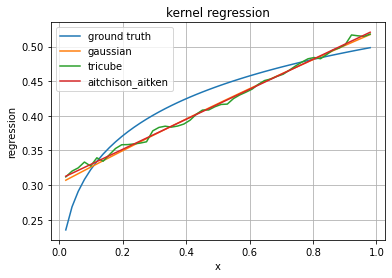

In [6]:
### ['gau', 'epa', 'uni', 'tri', 'biw', 'triw', 'cos', 'cos2']
kernels_regression =  ['gaussian','tricube', 'aitchison_aitken_reg']
results_regression = [cond_mean]
for kernel in kernels_regression:
    kde = KernelReg(endog=y_train, exog=x_train, var_type='c', ckertype=kernel) ## bw='cv_ls', 
    # estimator = kde.fit(np_x)[1][:,0]
    estimator = kde.fit(np_x)[0]
    results_regression.append(estimator)

labels = ['ground truth', 'gaussian', 'tricube', 'aitchison_aitken']
xylabels = ['x', 'regression']
title = 'kernel regression'
path = 'results/syn'
xaxis = np_x
plot_err(xaxis, results_regression, labels, xylabels, title, path)

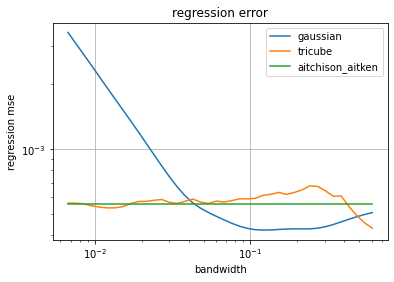

In [7]:
# bws = np.array([1e-2, 5e-2, 1e-1, 5e-1, 1.0, 2.0]).reshape(-1, 1)
bws = np.exp(np.linspace(-5, -0.5, 40)).reshape(-1, 1)
results_err = [0] * len(kernels_regression)
for i, kernel in enumerate(kernels_regression):
    result = []
    for bw in bws:
        kde = KernelReg(endog=y_train, exog=x_train, var_type='c', bw=bw, ckertype=kernel) ## bw='cv_ls', 
        # estimator = kde.fit(np_x)[1][:,0]
        estimator = kde.fit(np_x)[0]
        mse = mean_squared_error(cond_mean, estimator)
        result.append(mse)
    results_err[i] = result
    
labels = ['gaussian', 'tricube', 'aitchison_aitken']
xylabels = ['bandwidth', 'regression mse']
title = 'regression error'
path = 'results/syn'
xaxis = bws
plot_err(xaxis, results_err, labels, xylabels, title, path, plottype='loglog')

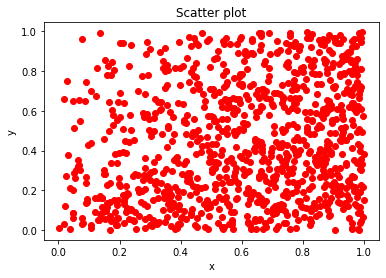

In [8]:
plt.figure()
plt.scatter(x_train, y_train, c='red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter plot')
plt.show()

In [9]:
# eg_length = 50
# np_x = np.linspace(-4, 4, eg_length)
length = max(np_x) - min(np_x)
pdf_true = (np_x - 1) / np.log(np_x) / np.log(2)

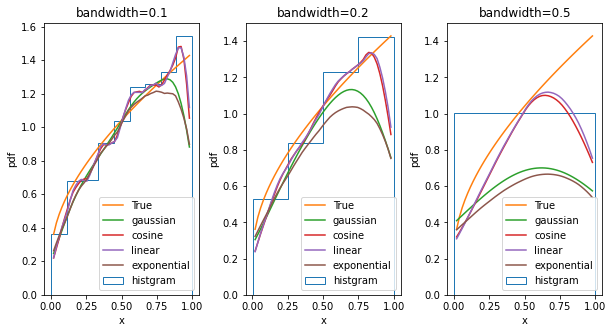

In [10]:
bws = [0.1, 0.2, 0.5]
kernels_kde = ['gaussian', 'cosine', 'linear', 'exponential']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.subplot(131)
bw = bws[0]
plt.hist(x_train, bins=int(np.floor(length/bw)), density=True, histtype='step', color=f'C{0}', label='histgram') # 
plt.plot(np_x, pdf_true, c=f'C{1}', label='True')
for i, kernel in enumerate(kernels_kde):
    kde = KernelDensity(kernel=kernel, bandwidth=bw).fit(x_train[:, np.newaxis])
    dens = np.exp(kde.score_samples(np_x[:, np.newaxis]))
    plt.plot(np_x, dens, c=f'C{i+2}', label=kernel)
plt.title(f'bandwidth={bw}')
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('pdf')
fig.subplots_adjust(wspace=.3)
plt.subplot(132)
bw = bws[1]
plt.hist(x_train, bins=int(np.floor(length/bw)), density=True, histtype='step', color=f'C{0}', label='histgram') # 
plt.plot(np_x, pdf_true, c=f'C{1}', label='True')
for i, kernel in enumerate(kernels_kde):
    kde = KernelDensity(kernel=kernel, bandwidth=bw).fit(x_train[:, np.newaxis])
    dens = np.exp(kde.score_samples(np_x[:, np.newaxis]))
    plt.plot(np_x, dens, c=f'C{i+2}', label=kernel)
plt.title(f'bandwidth={bw}')
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('pdf')
fig.subplots_adjust(wspace=.3)
plt.subplot(133)
bw = bws[2]
plt.hist(x_train, bins=int(np.floor(length/bw)), density=True, histtype='step', color=f'C{0}', label='histgram') # 
plt.plot(np_x, pdf_true, c=f'C{1}', label='True')
for i, kernel in enumerate(kernels_kde):
    kde = KernelDensity(kernel=kernel, bandwidth=bw).fit(x_train[:, np.newaxis])
    dens = np.exp(kde.score_samples(np_x[:, np.newaxis]))
    plt.plot(np_x, dens, c=f'C{i+2}', label=kernel)
plt.title(f'bandwidth={bw}')
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('pdf')
fig.subplots_adjust(wspace=.3)
plt.show()

In [11]:
def true_DP(np_x):
    cond_mean = (np_x*np.log(np_x) - np_x + 1) / np.log(np_x) / (np_x - 1)
    pdf_true = (np_x - 1) / np.log(np_x) / np.log(2)
    y_mean = 1 / np.log(2) - 1
    DP_true = np.sum(np.abs(cond_mean - y_mean) * pdf_true) / np.sum(pdf_true)
    return DP_true

In [12]:
num2 = int(1e3)
np_x2 = np.linspace(1/num2, 1-1/num2, num2)
DP_true = true_DP(np_x2)
DP_true

0.041629761183749614

In [13]:
def error_bw_single(bw, num, kernels_kde, kernels_regression):
    x_train, y_train = generate_data(num)

    eg_length = np.floor(1 / bw).astype(int)
    np_x = np.linspace(1/eg_length, 1-1/eg_length, eg_length)
    width = bw #np_x[1] - np_x[0]
    np_histx = np.concatenate(([np_x[0]-width/2], np_x + width/2), axis=0)

    num2 = int(1e4)
    np_x2 = np.linspace(1/num2, 1-1/num2, num2)
    DP_true = true_DP(np_x2)

    ## histogram
    (hist_pdf, _, _) = plt.hist(x_train, bins=np_histx, density=True, histtype='step') # 
    plt.close()
    hist_regressions = []
    inds = np.digitize(x_train, np_histx)
    # print(f'inds={inds}')
    for index_np in range(len(np_x)):
        index = np.where(inds==index_np+1)
        if index[0].size:
            hist_regression = np.mean(y_train[index])
        else:
            hist_regression = 0
        hist_regressions.append(hist_regression)

    results_regression = []
    eg_length = int(1e3)
    np_x = np.linspace(1/eg_length, 1-1/eg_length, eg_length)
    for kernel in kernels_regression:
        kde = KernelReg(endog=y_train, exog=x_train, var_type='c', bw=[width], ckertype=kernel) ## bw='cv_ls', 
        # estimator = kde.fit(np_x)[1][:,0]
        estimator = kde.fit(np_x)[0]
        results_regression.append(estimator)
    dens = []
    for i, kernel in enumerate(kernels_kde):
        kde = KernelDensity(kernel=kernel, bandwidth=width).fit(x_train[:, np.newaxis])
        den = np.exp(kde.score_samples(np_x[:, np.newaxis]))
        dens.append(den)
    # print(f'hist_regressions={hist_regressions}')
    # print(f'results_regression={results_regression}')
    # print(f'den={den}')
    DP_ests = []
    ### histgram
    DP_est = np.sum(np.abs(hist_regressions - np.mean(y_train)) * hist_pdf)/ np.sum(hist_pdf)
    DP_ests.append(DP_est)
    for j in range(len(kernels_regression)):
        for i in range(len(kernels_kde)):
            DP_est = np.sum(np.abs(results_regression[j] - np.mean(y_train)) * dens[i])/ np.sum(dens[i])
            DP_ests.append(DP_est)
    DP_ests = np.array(DP_ests)
    error = np.abs(DP_true - DP_ests)
    return error

In [14]:
def error_bw(bw, num, kernels_kde, kernels_regression, times=100):
    errors = Parallel(n_jobs=10)(delayed(error_bw_single)(bw, num, kernels_kde, kernels_regression) for i in range(times))
    errors = np.array(errors)
    return np.mean(errors, axis=0)

In [15]:
def error_optbw(bws, nums, kernels_kde, kernels_regression, times=100):
    errors_opt = np.ones((len(nums), 1+len(kernels_kde)*len(kernels_regression)))
    width_opt = np.zeros((len(nums), 1+len(kernels_kde)*len(kernels_regression)))
    for i, num in enumerate(nums):
        for bw in bws:
            errors = Parallel(n_jobs=10)(delayed(error_bw_single)(bw, num, kernels_kde, kernels_regression) for i in range(times))
            errors = np.mean(np.array(errors), axis=0)
            for j in range(len(errors)):
                if errors[j] < errors_opt[i, j]:
                    errors_opt[i, j] = errors[j]
                    width_opt[i, j] = bw
    return errors_opt.T, width_opt.T

In [16]:
kernels_regression =  ['tricube', 'aitchison_aitken_reg']
kernels_kde = ['linear', 'cosine']
num = int(1e4)
# bw = 0.1
bws = np.exp(np.linspace(-6, -2, 40))
# bws = [0.01]
errors = []
for bw in bws:
    error = error_bw(bw, num, kernels_kde, kernels_regression)
    # error = error_bw_single(bw, num, kernels_kde, kernels_regression)
    
    errors.append(list(error))
# errors

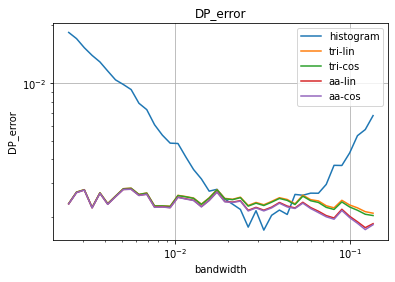

In [17]:
labels = ['histogram', 'tri-lin', 'tri-cos', 'aa-lin', 'aa-cos']
xylabels = ['bandwidth', 'DP_error']
title = 'DP_error'
# path = 'results/Gaussian'
xaxis = bws
errors_trans = list(np.array(errors).T)
plot_err(xaxis, errors_trans, labels, xylabels, title, path, plottype='loglog')##semilogx

In [18]:
kernels_regression =  ['tricube', 'aitchison_aitken_reg']
kernels_kde = ['linear', 'cosine']
# bw = 0.1
bws = np.exp(np.linspace(-6, -2, 40))
nums = np.floor(np.power(10, np.linspace(2, 5, 10))).astype(int) ## num = [10, 50, 100, 500, 1000, 2000, 5000]
errors_opt, width_opt = error_optbw(bws, nums, kernels_kde, kernels_regression, times=100)

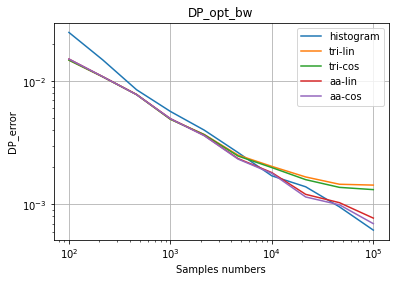

In [19]:
labels = ['histogram', 'tri-lin', 'tri-cos', 'aa-lin', 'aa-cos']
xylabels = ['Samples numbers', 'DP_error']
title = 'DP_opt_bw'
# path = 'results/Gaussian'
xaxis = nums
plot_err(xaxis, errors_opt, labels, xylabels, title, path, plottype='loglog')##semilogx

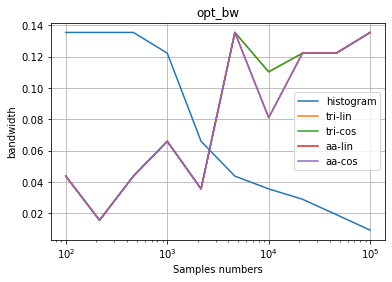

In [20]:
labels = ['histogram', 'tri-lin', 'tri-cos', 'aa-lin', 'aa-cos']
xylabels = ['Samples numbers', 'bandwidth']
title = 'opt_bw'
# path = 'results/Gaussian'
xaxis = nums
plot_err(xaxis, width_opt, labels, xylabels, title, path, plottype='semilogx')##semilogx